In [1]:
import pandas as pd

# Path to the spreadsheet

metadata_path = 'ECGPCGSpreadsheet.csv'

# Read the spreadsheet
metadata = pd.read_csv(metadata_path)

print(metadata.head())


  Record Name Subject ID  Record Duration (min)  Age (years) Gender  \
0  ECGPCG0001       S023                   30.0          NaN   Male   
1  ECGPCG0002       S024                   30.0          NaN   Male   
2  ECGPCG0003       S003                    0.5         28.0   Male   
3  ECGPCG0004       S004                    0.5         26.0   Male   
4  ECGPCG0005       S005                    0.5         23.0   Male   

                        Recording Scenario  Num Channels  \
0  exercise: pedaling a stationary bicycle             2   
1  exercise: pedaling a stationary bicycle             2   
2                rest: sitting on armchair             2   
3                rest: sitting on armchair             5   
4                rest: sitting on armchair             5   

                     ECG Notes                         PCG Notes  \
0                         Good                              Good   
1  Good; occasional saturation                              Good   
2       

In [2]:
import wfdb
import numpy as np
import os

# Path to the WFDB files
wfdb_path = 'WFDB'

# Get a list of record names
record_names = metadata['Record Name'].tolist()


In [3]:
import wfdb
import numpy as np
import os


def load_signals(record_name, data_path, num_channels=2):
    record_path = os.path.join(data_path, record_name)
    signal, fields = wfdb.rdsamp(record_path, channels=list(range(num_channels)))
    return signal

In [4]:
import numpy as np
import gc
import os

# Directory to save signals
signal_dir = 'saved_signals'
if not os.path.exists(signal_dir):
    os.makedirs(signal_dir)
    print(f"Created directory '{signal_dir}' for storing signal files.\n")

# Updated mapping for scenarios based on your dataset
scenario_to_intensity = {
    'exercise: pedaling a stationary bicycle': 1,
    'rest: sitting on armchair': 2,
    'rest: laying on bed': 3,
    'exercise: slow walk (7 min); fast walk (8 min); sit down and stand up (4 min); slow walk (6 min); rest': 4,
    'exercise: bruce protocol treadmill stress test': 5,
    'exercise: walking at constant speed (3.7 km/h)': 6,
    'exercise: bicycle stress test': 7
}

wfdb_path = 'WFDB'

for idx, row in metadata.iterrows():
    record_name = row['Record Name']
    scenario = row['Recording Scenario']
    
    # Normalize scenario text to match the dictionary keys
    scenario_normalized = scenario.lower().strip()
    intensity = scenario_to_intensity.get(scenario_normalized)
    
    if intensity is None:
        print(f"Skipping unknown scenario: '{scenario}'")
        continue  # Skip if the scenario is not in the mapping
    
    try:
        # Determine the number of channels
        num_channels = int(row['Num Channels'])
        
        # Load the signal data
        print(f"Processing record '{record_name}' with scenario '{scenario}' and {num_channels} channels.")
        signal = load_signals(record_name, wfdb_path, num_channels=num_channels)
        
        # Handle 2-channel and 5-channel records
        if num_channels == 2:
            ecg_signal = signal[:, 0]  # ECG
            pcg_signal = signal[:, 1]  # PCG
        elif num_channels == 5:
            ecg_signal = signal[:, 0]  # ECG
            pcg_signal = signal[:, 1]  # PCG
        else:
            print(f"Unexpected number of channels ({num_channels}) in record '{record_name}'. Skipping this record.")
            del signal  # Free memory
            continue  # Skip this record
        
        # Save signals to a file
        file_path = os.path.join(signal_dir, f'{record_name}.npz')
        np.savez_compressed(file_path, ecg=ecg_signal, pcg=pcg_signal, label=intensity - 1)
        print(f"Saved signals for record '{record_name}' to '{file_path}'.\n")
        
        # Clear variables and run garbage collection
        del signal, ecg_signal, pcg_signal
        gc.collect()

    except Exception as e:
        print(f"Error loading '{record_name}': {e}\n")
        continue  # Move on to the next record if there's an error

print("Finished processing all records and saving to files.\n")

Created directory 'saved_signals' for storing signal files.

Processing record 'ECGPCG0001' with scenario 'exercise: pedaling a stationary bicycle' and 2 channels.
Saved signals for record 'ECGPCG0001' to 'saved_signals\ECGPCG0001.npz'.

Processing record 'ECGPCG0002' with scenario 'exercise: pedaling a stationary bicycle' and 2 channels.
Saved signals for record 'ECGPCG0002' to 'saved_signals\ECGPCG0002.npz'.

Processing record 'ECGPCG0003' with scenario 'rest: sitting on armchair' and 2 channels.
Saved signals for record 'ECGPCG0003' to 'saved_signals\ECGPCG0003.npz'.

Processing record 'ECGPCG0004' with scenario 'rest: sitting on armchair' and 5 channels.
Saved signals for record 'ECGPCG0004' to 'saved_signals\ECGPCG0004.npz'.

Processing record 'ECGPCG0005' with scenario 'rest: sitting on armchair' and 5 channels.
Saved signals for record 'ECGPCG0005' to 'saved_signals\ECGPCG0005.npz'.

Processing record 'ECGPCG0006' with scenario 'rest: sitting on armchair' and 5 channels.
Saved s

In [6]:
import matplotlib.pyplot as plt
import gc
import numpy as np

# Directory to save images
image_dir = 'ecg_pcg_images'
if not os.path.exists(image_dir):
    os.makedirs(image_dir)
    print(f"Created directory '{image_dir}' for storing images.\n")

image_paths = []
image_labels = []

print("Starting to segment signals and create images...\n")

# Define the sample length (number of data points per segment)
sample_length = 10000  # Adjust as needed based on your data and resources
max_segments_per_signal = 100  # Limit number of segments per signal

def segment_signal(signal, sample_length):
    num_segments = len(signal) // sample_length
    return [signal[i * sample_length: (i + 1) * sample_length] for i in range(num_segments)]

for filename in os.listdir(signal_dir):
    file_path = os.path.join(signal_dir, filename)
    data = np.load(file_path)
    ecg_signal = data['ecg']
    pcg_signal = data['pcg']
    label = int(data['label'])
    print(f"Processing '{filename}' with label {label}")

    # Segment ECG and PCG signals
    ecg_segments = segment_signal(ecg_signal, sample_length)
    pcg_segments = segment_signal(pcg_signal, sample_length)
    num_segments_to_process = min(len(ecg_segments), max_segments_per_signal)
    
    for j in range(num_segments_to_process):
        ecg_segment = ecg_segments[j]
        pcg_segment = pcg_segments[j]
        
        # Plot and save image
        plt.figure(figsize=(4, 3))
        plt.plot(ecg_segment, label='ECG')
        plt.plot(pcg_segment, label='PCG')
        plt.legend(loc='upper right')
        plt.axis('off')
        
        image_name = f'{filename}segment{j}.png'
        image_path = os.path.join(image_dir, image_name)
        plt.savefig(image_path, dpi=150, bbox_inches='tight', pad_inches=0)
        plt.close()
        
        image_paths.append(image_path)
        image_labels.append(label)
        
        del ecg_segment, pcg_segment  # Clear segment data to save memory
    
    # Clear loaded signal data after processing
    del data, ecg_signal, pcg_signal, ecg_segments, pcg_segments
    gc.collect()
    print(f"Finished processing '{filename}'\n")

print(f"Total images created: {len(image_paths)}\n")

Starting to segment signals and create images...

Processing 'ECGPCG0001.npz' with label 0
Finished processing 'ECGPCG0001.npz'

Processing 'ECGPCG0002.npz' with label 0
Finished processing 'ECGPCG0002.npz'

Processing 'ECGPCG0003.npz' with label 1
Finished processing 'ECGPCG0003.npz'

Processing 'ECGPCG0004.npz' with label 1
Finished processing 'ECGPCG0004.npz'

Processing 'ECGPCG0005.npz' with label 1
Finished processing 'ECGPCG0005.npz'

Processing 'ECGPCG0006.npz' with label 1
Finished processing 'ECGPCG0006.npz'

Processing 'ECGPCG0007.npz' with label 1
Finished processing 'ECGPCG0007.npz'

Processing 'ECGPCG0008.npz' with label 1
Finished processing 'ECGPCG0008.npz'

Processing 'ECGPCG0009.npz' with label 1
Finished processing 'ECGPCG0009.npz'

Processing 'ECGPCG0010.npz' with label 1
Finished processing 'ECGPCG0010.npz'

Processing 'ECGPCG0011.npz' with label 1
Finished processing 'ECGPCG0011.npz'

Processing 'ECGPCG0012.npz' with label 1
Finished processing 'ECGPCG0012.npz'

Pr

In [7]:
import pandas as pd

# Create a DataFrame with image paths and labels
data = pd.DataFrame({
    'image_path': image_paths,
    'label': image_labels
})

print(f"Total images: {len(data)}")
print(data.head())

Total images: 6292
                                  image_path  label
0  ecg_pcg_images\ECGPCG0001.npzsegment0.png      0
1  ecg_pcg_images\ECGPCG0001.npzsegment1.png      0
2  ecg_pcg_images\ECGPCG0001.npzsegment2.png      0
3  ecg_pcg_images\ECGPCG0001.npzsegment3.png      0
4  ecg_pcg_images\ECGPCG0001.npzsegment4.png      0


In [22]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class CustomDataGenerator(Sequence):
    def __init__(self, df, batch_size=32, img_height=224, img_width=224, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()
        
    def __len__(self):
        # Denotes the number of batches per epoch
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        # Generate one batch of data
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        X, y = self.__data_generation(batch_df)
        return X, y
    
    def on_epoch_end(self):
        # Updates indices after each epoch
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __data_generation(self, batch_df):
        # Generates data containing batch_size samples
        X = []
        y = []
        for idx, row in batch_df.iterrows():
            img_path = row['image_path']
            label = row['label']
            # Load and preprocess image
            img = load_img(img_path, target_size=(self.img_height, self.img_width), color_mode='rgb')
            img_array = img_to_array(img) / 255.0
            X.append(img_array)
            y.append(label)
        X = np.array(X)
        y = np.array(y)
        return X, y

In [23]:
from sklearn.model_selection import train_test_split

print("Splitting data into training and validation sets...\n")
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])
print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")


Splitting data into training and validation sets...

Training samples: 5033, Validation samples: 1259


In [24]:
batch_size = 32
img_height = 224
img_width = 224

train_generator = CustomDataGenerator(train_df, batch_size=batch_size, img_height=img_height, img_width=img_width)
val_generator = CustomDataGenerator(val_df, batch_size=batch_size, img_height=img_height, img_width=img_width, shuffle=False)

In [26]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

print("Building the CNN model using transfer learning...\n")

num_classes = data['label'].nunique()  # Number of unique classes

# Load the VGG16 model pre-trained on ImageNet, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Model built and compiled. Summary:")
model.summary()
print("\n")


Building the CNN model using transfer learning...

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Model built and compiled. Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [27]:
epochs = 10  # Adjust based on your resources

print("Starting model training...\n")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    verbose=1
)
print("\nModel training completed.\n")

Starting model training...



e:\ECG\Ecg\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1981s 13s/step - accuracy: 0.2703 - loss: 1.8106 - val_accuracy: 0.4353 - val_loss: 1.5161
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1597s 10s/step - accuracy: 0.4746 - loss: 1.4456 - val_accuracy: 0.5592 - val_loss: 1.2801
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1712s 11s/step - accuracy: 0.5502 - loss: 1.2490 - val_accuracy: 0.6219 - val_loss: 1.1242
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1615s 10s/step - accuracy: 0.6160 - loss: 1.1151 - val_accuracy: 0.6219 - val_loss: 1.0163
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1892s 12s/step - accuracy: 0.6453 - loss: 1.0083 - val_accuracy: 0.6878 - val_loss: 0.8990
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1871s 12s/step - accuracy: 0.6845 - loss: 0.9096 - val_accuracy: 0.6990 - val_loss: 0.8514
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1847s 12s/step - accuracy: 0.6868 - loss: 0.8764 - val_accuracy: 0.7149 - val_loss: 0.8022
Epoch 8/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1859s 12s/step - accuracy: 0.7012 - loss: 0

In [28]:
print("Evaluating the model on validation data...\n")
val_loss, val_acc = model.evaluate(val_generator, verbose=2)
print(f'\nValidation accuracy: {val_acc*100:.2f}%')
print(f'Validation loss: {val_loss}\n')

Evaluating the model on validation data...

40/40 - 309s - 8s/step - accuracy: 0.7450 - loss: 0.7227

Validation accuracy: 74.50%
Validation loss: 0.7227362990379333



In [29]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

print("Generating classification report and confusion matrix...\n")

# Get true labels and predicted labels
y_true = val_df['label'].values
y_pred = []

for i in range(len(val_generator)):
    X_batch, y_batch = val_generator[i]
    y_pred_batch = model.predict(X_batch)
    y_pred_classes = np.argmax(y_pred_batch, axis=1)
    y_pred.extend(y_pred_classes)

y_pred = np.array(y_pred)

print("Classification Report:\n")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n")
print(cm)

Generating classification report and confusion matrix...

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━

Visualizing training history...



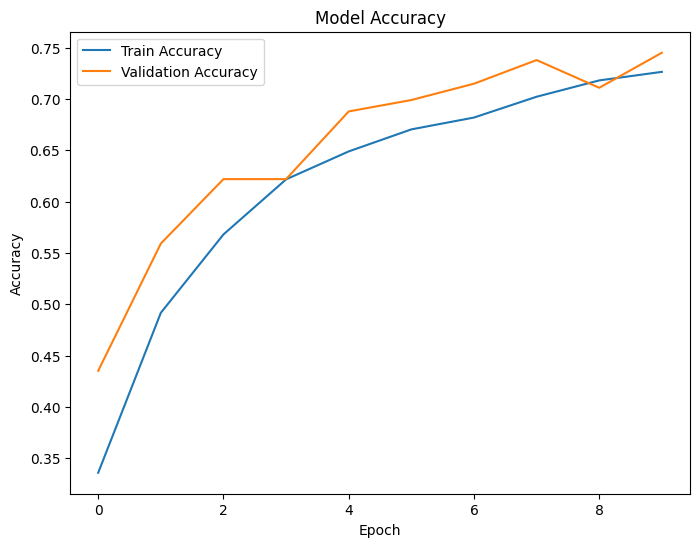

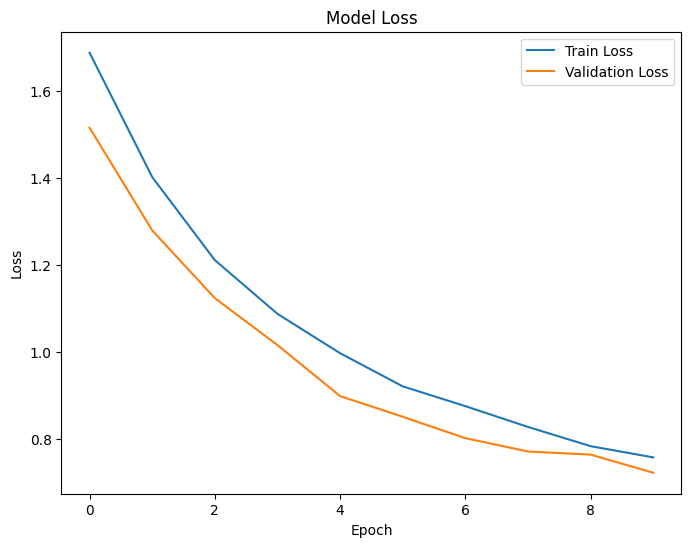

In [30]:
import matplotlib.pyplot as plt

print("Visualizing training history...\n")

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plotting confusion matrix...



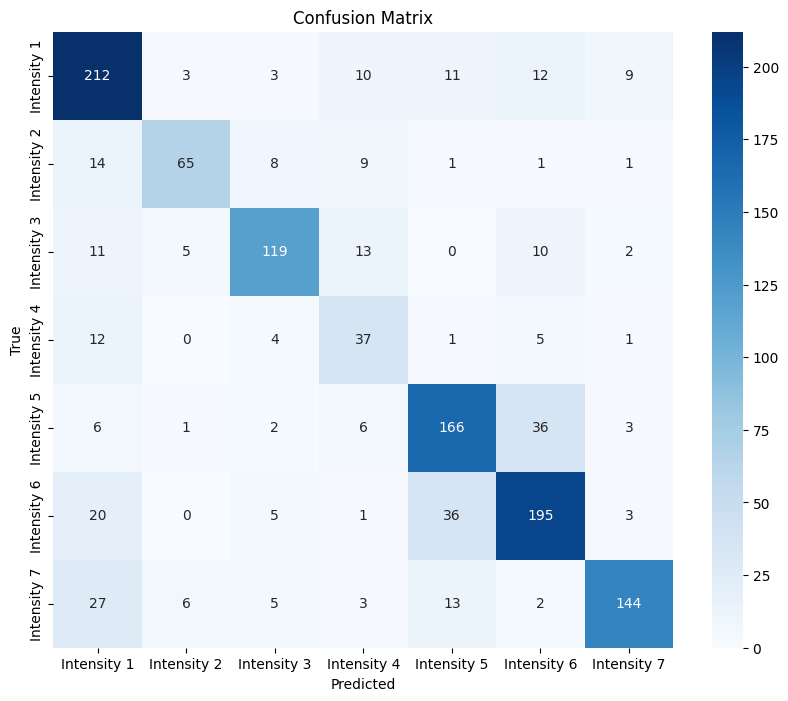

In [31]:
import seaborn as sns

print("Plotting confusion matrix...\n")
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Intensity {i+1}' for i in range(num_classes)],
            yticklabels=[f'Intensity {i+1}' for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()